In [1]:
!python --version

Python 3.8.18


In [ ]:
!pip install -r requirements.txt

In [12]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from lag_llama.gluon.estimator import LagLlamaEstimator

In [ ]:
pip install scipy

In [13]:
dataset = get_dataset("pedestrian_counts")

backtest_dataset = dataset.test
prediction_length = dataset.metadata.prediction_length
context_length = 32

Download pedestrian_counts_dataset.zip:: 4.38MB [00:23, 193kB/s]                            
creating json files: 100%|██████████| 66/66 [00:00<00:00, 66704.59it/s]


In [14]:
#ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cuda:0'))
ckpt = torch.load('lag-llama.ckpt', map_location=torch.device('cpu'))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

In [15]:
estimator = LagLlamaEstimator(
    ckpt_path="lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=context_length,

    # estimator args
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
)

lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

In [16]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=predictor,
)

In [17]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [18]:
evaluator = Evaluator()

In [19]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 66it [00:00, 109.78it/s]


In [20]:
print("CRPS:", agg_metrics['mean_wQuantileLoss'])

CRPS: 0.2533606943200015


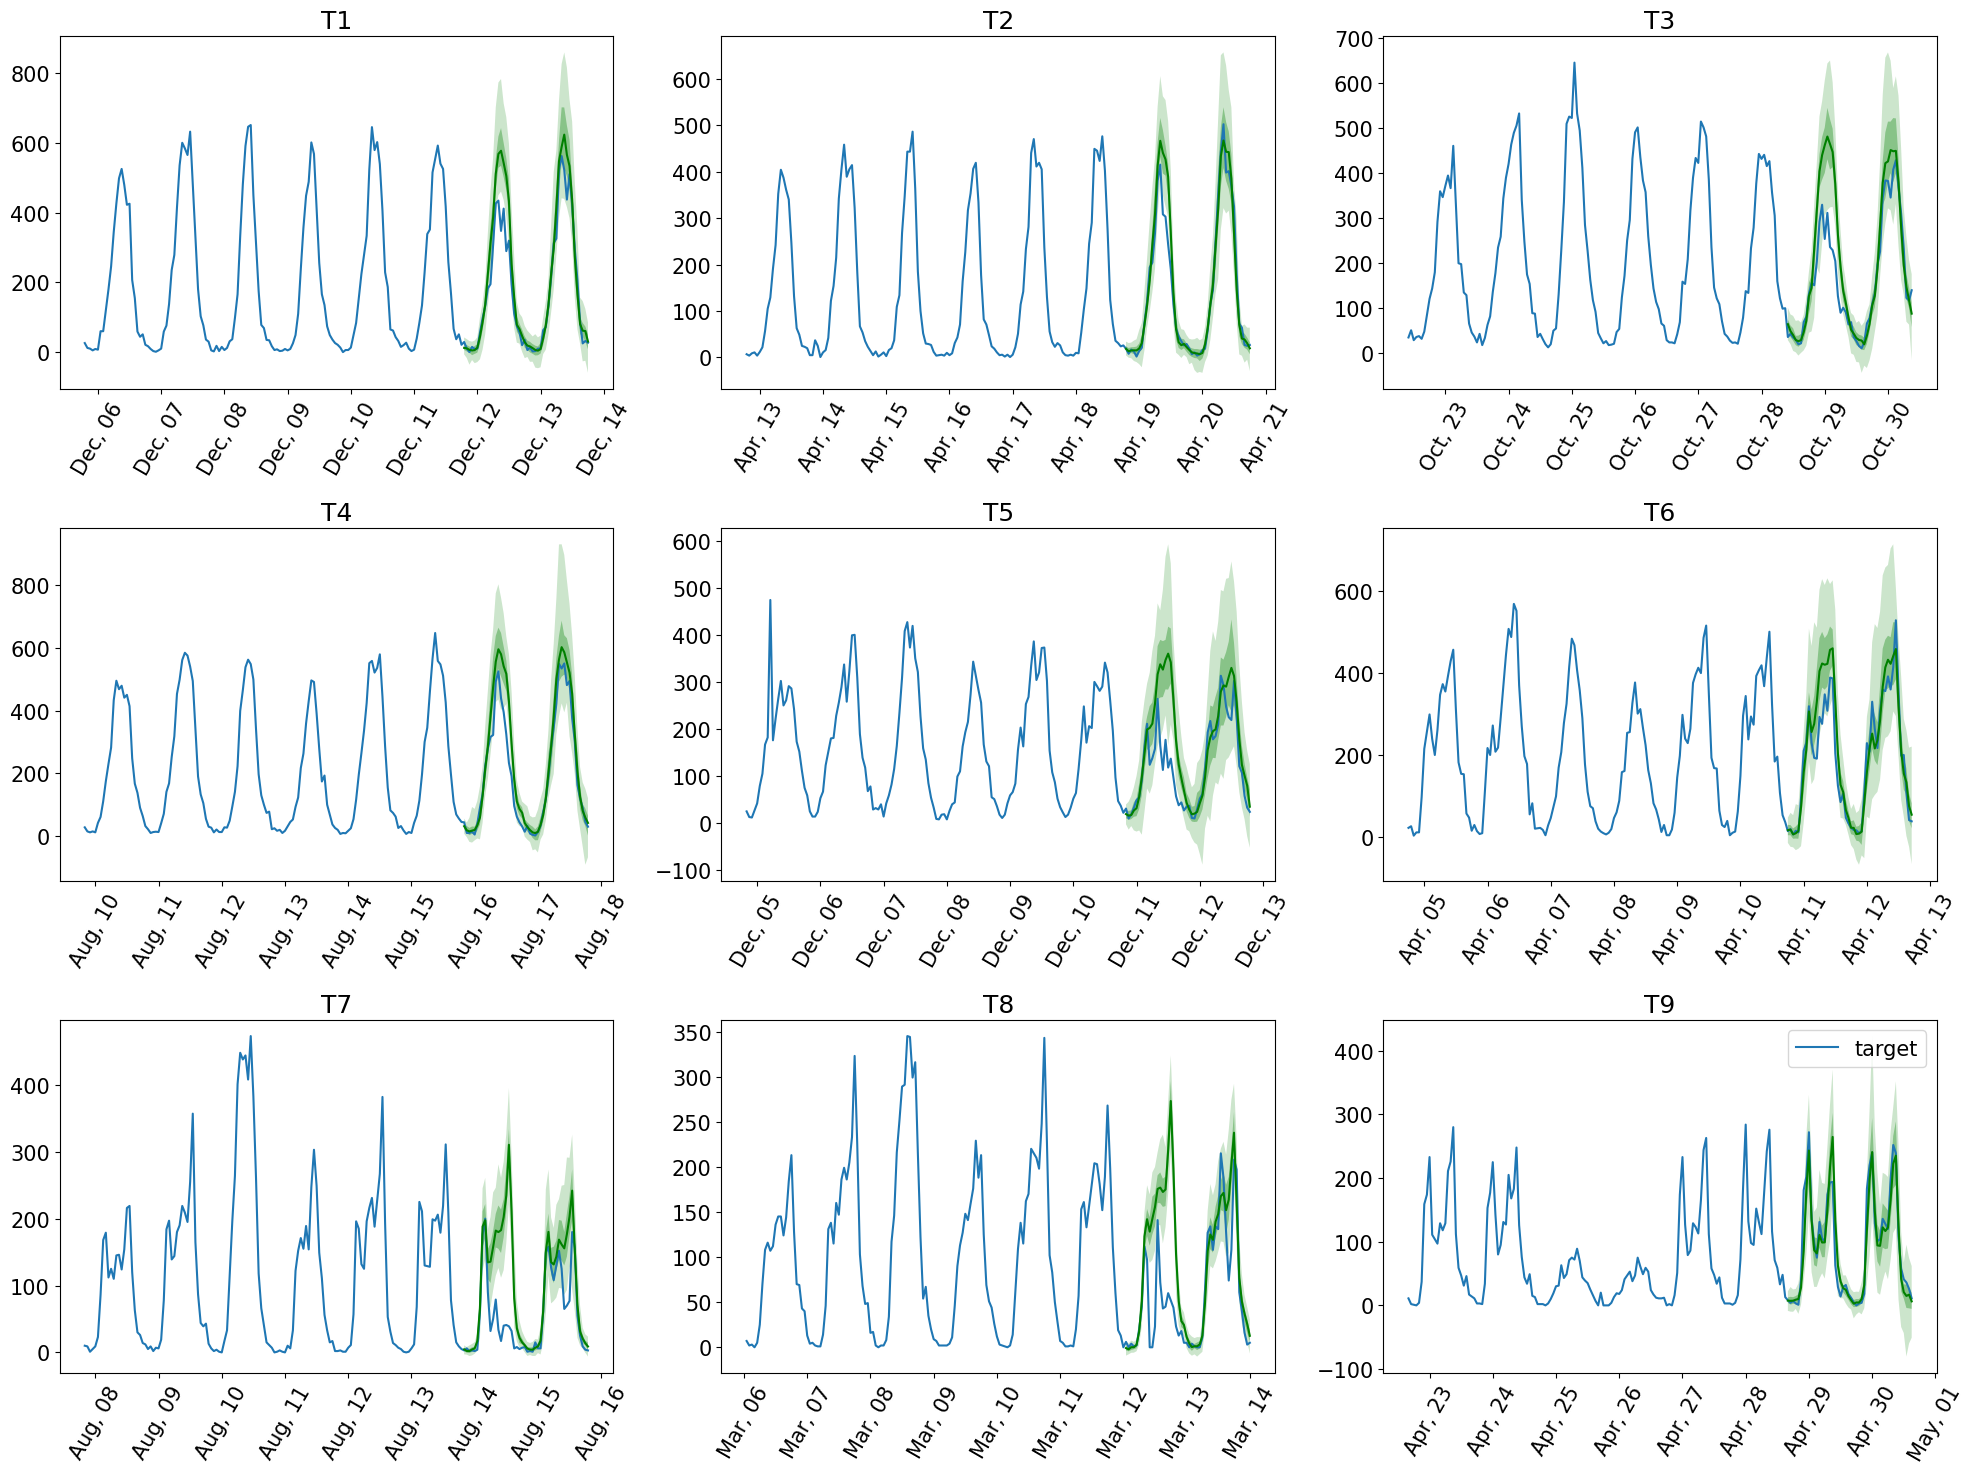

In [21]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

Forecast

In [22]:
dataset_new = get_dataset("airpassengers")


backtest_dataset_new = dataset.test
prediction_length_new = dataset.metadata.prediction_length
context_length_new = 32

In [23]:
estimator_new = LagLlamaEstimator(
    ckpt_path="lag-llama.ckpt",
    prediction_length=prediction_length_new,
    context_length=context_length_new,

    # estimator args
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
)

lightning_module_new = estimator_new.create_lightning_module()
transformation_new = estimator_new.create_transformation()
predictor_new = estimator_new.create_predictor(transformation_new, lightning_module_new)

In [24]:
forecast_it_new, ts_it_new = make_evaluation_predictions(
    dataset=backtest_dataset_new,
    predictor=predictor_new,
)

In [25]:
forecasts_new = list(forecast_it_new)
tss_new = list(ts_it_new)

In [26]:
evaluator_new = Evaluator()

In [27]:
agg_metrics_new, ts_metrics_new = evaluator_new(iter(tss_new), iter(forecasts_new))

Running evaluation: 66it [00:00, 67.30it/s]


In [28]:
print("CRPS:", agg_metrics_new['mean_wQuantileLoss'])

CRPS: 0.2550816314058875


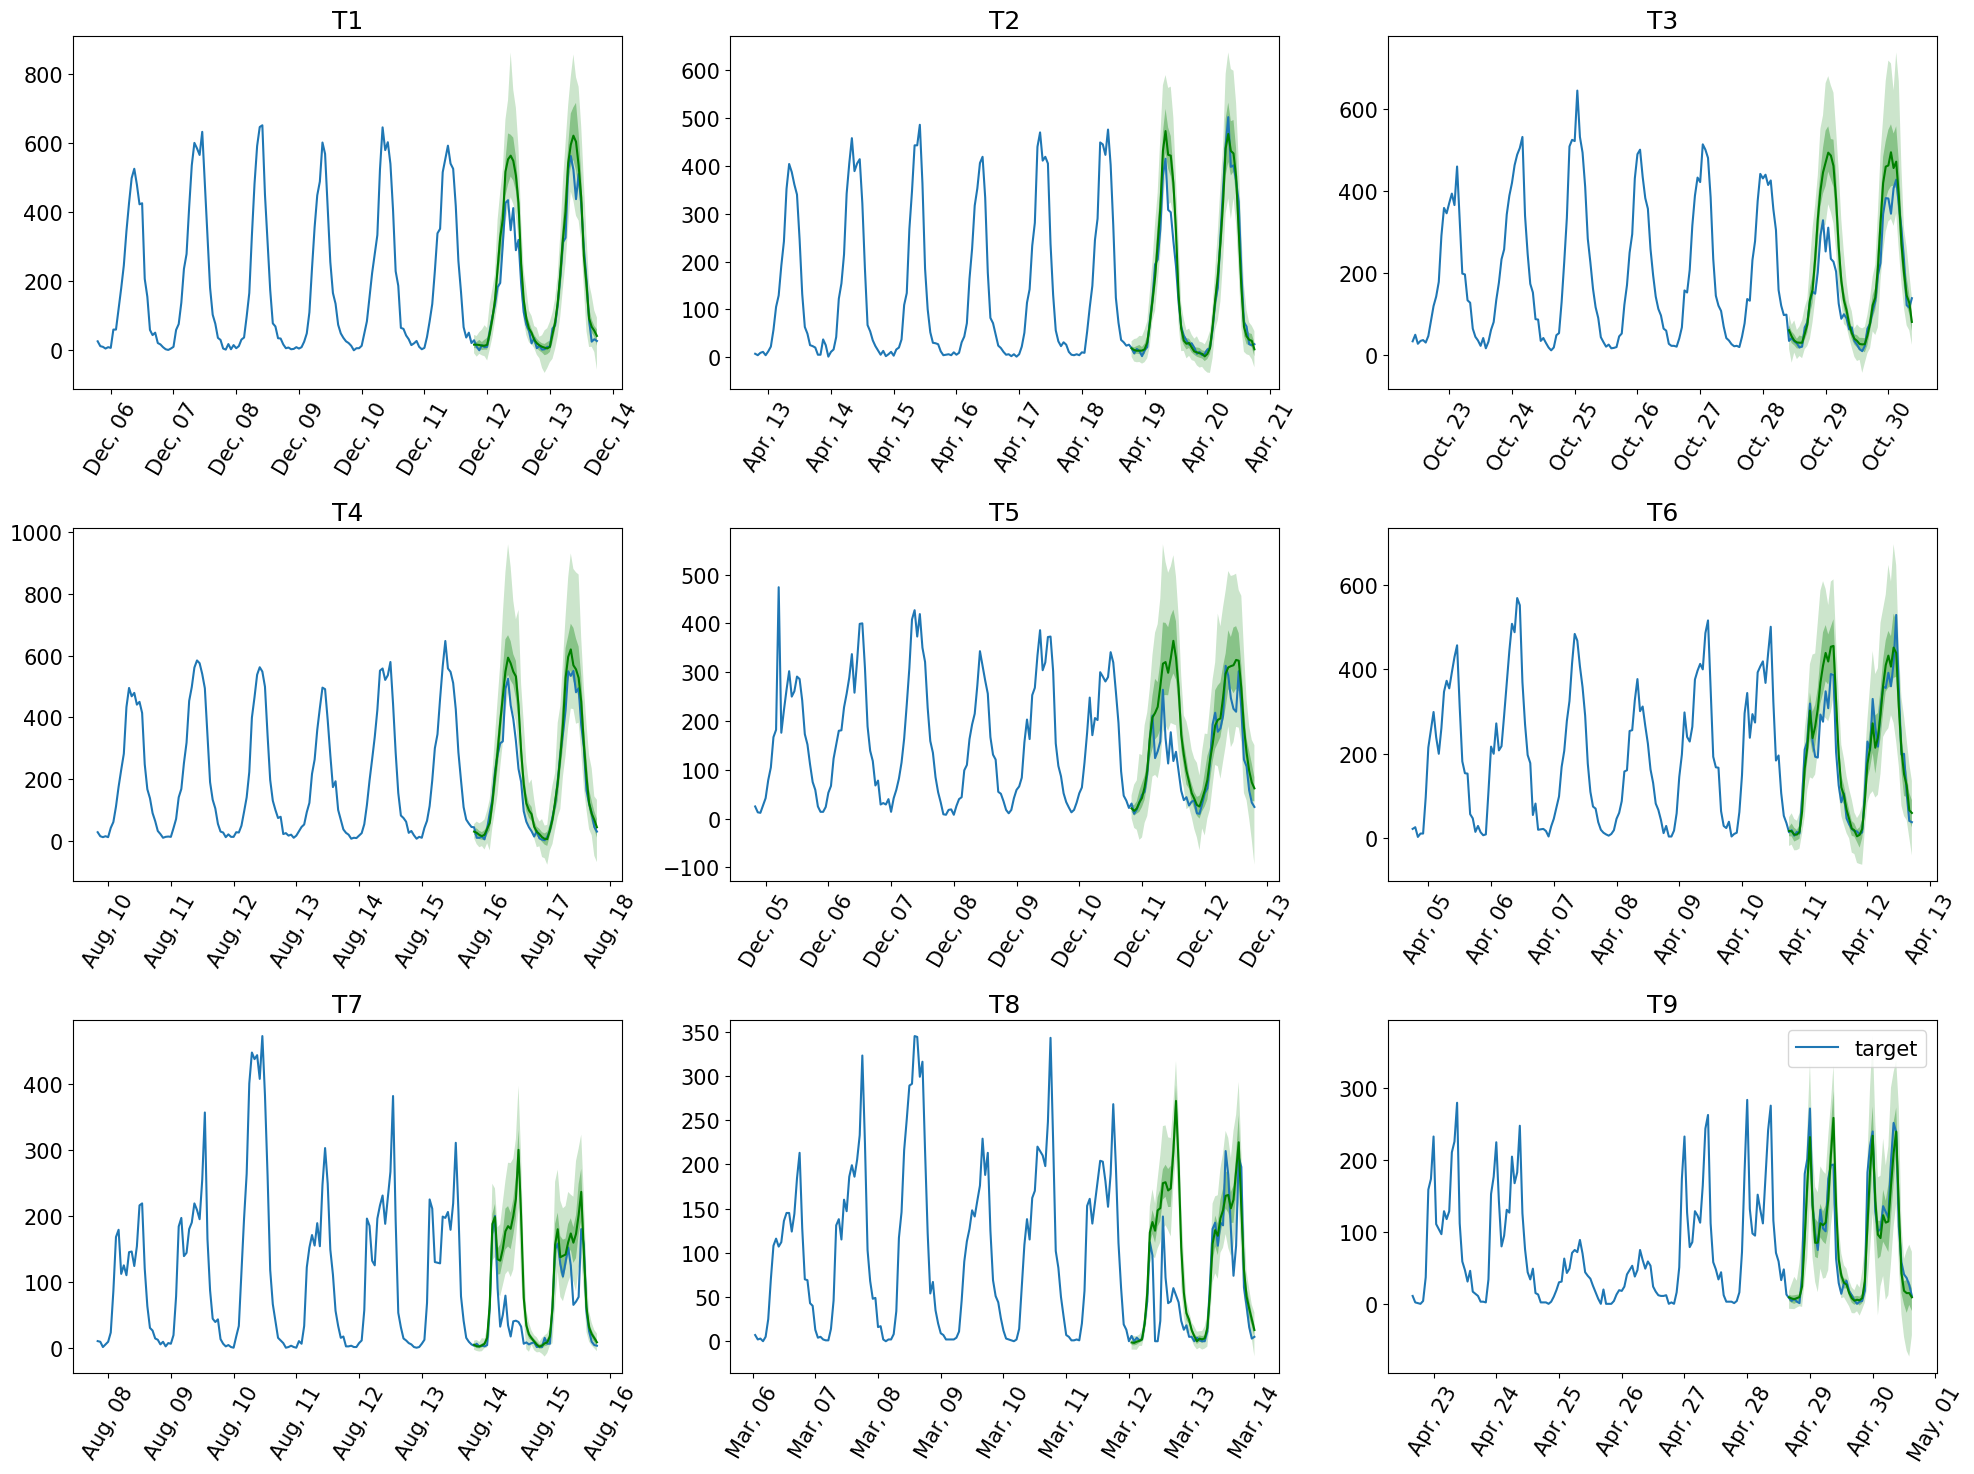

In [29]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_new, tss_new)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()